In [102]:
# compare tasks (cookieTheft, picnicScene, journaling) to see which task's feature set best predicts a target score

# setup
import sys
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")
from config.constants import GIT_DIRECTORY
from regression.regression_helpers import stratified_cross_validation

# target
target = "PhonemicFluencyScore"

# define tasks and feature type to compare
tasks = ["cookieTheft", "picnicScene", "journaling"]
feature_type = "full"  # or "linguistic", "acoustic", etc.

# load scores & demographic data
scores_path = os.path.join(GIT_DIRECTORY, "data/language_scores_all_subjects.csv")
demographics_path = os.path.join(GIT_DIRECTORY, "data/demographics_data.csv")
scores = pd.read_csv(scores_path)
demographics = pd.read_csv(demographics_path)

# save path
save_path = os.path.join(GIT_DIRECTORY, "results", "regression", "model_comparison", "filtered", "tasks")

In [103]:
# prepare demographics
demographics["Gender"] = demographics["Gender"].map({"f": 0, "m": 1})
education_map = {
    "less_than_highschool": 1,
    "high_school": 2,
    "vocational": 3,
    "bachelor": 4,
    "master": 5,
    "phd": 6,
    "no_answer": np.nan
}
demographics["Education"] = demographics["Education"].map(education_map)
demographics["Country"] = demographics["Country"].map({"uk": 0, "usa": 1})
demographics.drop(columns=["Language"], inplace=True)


In [104]:
# define feature sets
# full possible feature lists
linguistic_features = {
    "n_words", "ttr", "mattr_10", "mattr_20", "mattr_30", "mattr_40", "mattr_50", "filler_word_ratio",
    "average_word_length", "brunets_index", "honores_statistic", "guirauds_statistic", "light_verb_ratio",
    "empty_word_ratio", "nid_ratio", "adjacent_repetitions", "aoa_content", "aoa_nouns", "aoa_verbs",
    "fam_content", "fam_nouns", "fam_verbs", "img_content", "img_nouns", "img_verbs", "freq_content",
    "freq_nouns", "freq_verbs", "concr_content", "concr_nouns", "concr_verbs", "um_ratio", "uh_ratio",
    "er_ratio", "ah_ratio", "ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART",
    "PRON", "PROPN", "SCONJ", "VERB", "OTHER", "NOUN/VERB", "PRON/NOUN", "DET/NOUN", "AUX/VERB",
    "OPEN/CLOSED", "INFORMATION_WORDS", "article_pause_contentword"
}
acoustic_features = {
    "phonation_rate", "total_speech_duration", "speech_rate_phonemes", "speech_rate_words", "n_pauses",
    "total_pause_duration", "avg_pause_duration", "short_pause_count", "long_pause_count", "pause_word_ratio",
    "pause_ratio", "pause_rate",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_amean", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_percentile20.0", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_percentile50.0",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_percentile80.0", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope",
    "eGeMAPS_loudness_sma3_amean", "eGeMAPS_loudness_sma3_stddevNorm", "eGeMAPS_loudness_sma3_percentile20.0",
    "eGeMAPS_loudness_sma3_percentile50.0", "eGeMAPS_loudness_sma3_percentile80.0", "eGeMAPS_loudness_sma3_pctlrange0-2",
    "eGeMAPS_loudness_sma3_meanRisingSlope", "eGeMAPS_loudness_sma3_stddevRisingSlope",
    "eGeMAPS_loudness_sma3_meanFallingSlope", "eGeMAPS_loudness_sma3_stddevFallingSlope",
    "eGeMAPS_spectralFlux_sma3_amean", "eGeMAPS_spectralFlux_sma3_stddevNorm",
    "eGeMAPS_mfcc1_sma3_amean", "eGeMAPS_mfcc1_sma3_stddevNorm", "eGeMAPS_mfcc2_sma3_amean",
    "eGeMAPS_mfcc2_sma3_stddevNorm", "eGeMAPS_mfcc3_sma3_amean", "eGeMAPS_mfcc3_sma3_stddevNorm",
    "eGeMAPS_mfcc4_sma3_amean", "eGeMAPS_mfcc4_sma3_stddevNorm",
    "eGeMAPS_jitterLocal_sma3nz_amean", "eGeMAPS_jitterLocal_sma3nz_stddevNorm",
    "eGeMAPS_shimmerLocaldB_sma3nz_amean", "eGeMAPS_shimmerLocaldB_sma3nz_stddevNorm",
    "eGeMAPS_HNRdBACF_sma3nz_amean", "eGeMAPS_HNRdBACF_sma3nz_stddevNorm",
    "eGeMAPS_logRelF0-H1-H2_sma3nz_amean", "eGeMAPS_logRelF0-H1-H2_sma3nz_stddevNorm",
    "eGeMAPS_logRelF0-H1-A3_sma3nz_amean", "eGeMAPS_logRelF0-H1-A3_sma3nz_stddevNorm",
    "eGeMAPS_F1frequency_sma3nz_amean", "eGeMAPS_F1frequency_sma3nz_stddevNorm",
    "eGeMAPS_F1bandwidth_sma3nz_amean", "eGeMAPS_F1bandwidth_sma3nz_stddevNorm",
    "eGeMAPS_F1amplitudeLogRelF0_sma3nz_amean", "eGeMAPS_F1amplitudeLogRelF0_sma3nz_stddevNorm",
    "eGeMAPS_F2frequency_sma3nz_amean", "eGeMAPS_F2frequency_sma3nz_stddevNorm",
    "eGeMAPS_F2bandwidth_sma3nz_amean", "eGeMAPS_F2bandwidth_sma3nz_stddevNorm",
    "eGeMAPS_F2amplitudeLogRelF0_sma3nz_amean", "eGeMAPS_F2amplitudeLogRelF0_sma3nz_stddevNorm",
    "eGeMAPS_F3frequency_sma3nz_amean", "eGeMAPS_F3frequency_sma3nz_stddevNorm",
    "eGeMAPS_F3bandwidth_sma3nz_amean", "eGeMAPS_F3bandwidth_sma3nz_stddevNorm",
    "eGeMAPS_F3amplitudeLogRelF0_sma3nz_amean", "eGeMAPS_F3amplitudeLogRelF0_sma3nz_stddevNorm",
    "eGeMAPS_alphaRatioV_sma3nz_amean", "eGeMAPS_alphaRatioV_sma3nz_stddevNorm",
    "eGeMAPS_hammarbergIndexV_sma3nz_amean", "eGeMAPS_hammarbergIndexV_sma3nz_stddevNorm",
    "eGeMAPS_slopeV0-500_sma3nz_amean", "eGeMAPS_slopeV0-500_sma3nz_stddevNorm",
    "eGeMAPS_slopeV500-1500_sma3nz_amean", "eGeMAPS_slopeV500-1500_sma3nz_stddevNorm",
    "eGeMAPS_spectralFluxV_sma3nz_amean", "eGeMAPS_spectralFluxV_sma3nz_stddevNorm",
    "eGeMAPS_mfcc1V_sma3nz_amean", "eGeMAPS_mfcc1V_sma3nz_stddevNorm",
    "eGeMAPS_mfcc2V_sma3nz_amean", "eGeMAPS_mfcc2V_sma3nz_stddevNorm",
    "eGeMAPS_mfcc3V_sma3nz_amean", "eGeMAPS_mfcc3V_sma3nz_stddevNorm",
    "eGeMAPS_mfcc4V_sma3nz_amean", "eGeMAPS_mfcc4V_sma3nz_stddevNorm",
    "eGeMAPS_alphaRatioUV_sma3nz_amean", "eGeMAPS_hammarbergIndexUV_sma3nz_amean",
    "eGeMAPS_slopeUV0-500_sma3nz_amean", "eGeMAPS_slopeUV500-1500_sma3nz_amean",
    "eGeMAPS_spectralFluxUV_sma3nz_amean",
    "eGeMAPS_loudnessPeaksPerSec", "eGeMAPS_VoicedSegmentsPerSec", "eGeMAPS_MeanVoicedSegmentLengthSec",
    "eGeMAPS_StddevVoicedSegmentLengthSec", "eGeMAPS_MeanUnvoicedSegmentLength",
    "eGeMAPS_StddevUnvoicedSegmentLength", "eGeMAPS_equivalentSoundLevel_dBp"
}

# set up models (select available features inside loop later)
demographic_cols = ["Age", "Gender", "Education", "Country", "Socioeconomic"]

model_configs = {
    "baseline": [],
    "demographics": demographic_cols,
    "linguistic": sorted(list(linguistic_features)),
    "acoustic": sorted(list(acoustic_features)),
    "linguistic+acoustic": sorted(list(linguistic_features | acoustic_features)),
    "full": sorted(list(linguistic_features | acoustic_features)) + demographic_cols
}

model_order = ["baseline", "demographics", "linguistic", "acoustic", "linguistic+acoustic", "full"]
task_order = ["cookieTheft", "picnicScene", "journaling"]

In [105]:
# define type of regression
model_type = LinearRegression
# for saving later
model_type_name = model_type.__name__

fold_results = []

# loop over tasks
for task_name in tasks:
    for model_name, selected_features in model_configs.items():
        print(f"running task: {task_name} | model: {model_name}")

        # paths
        features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task_name}_filtered.csv")
        folds_path = os.path.join(GIT_DIRECTORY, "data/stratified_folds.csv")

        # load data
        features = pd.read_csv(features_path)
        folds = pd.read_csv(folds_path)

        # merge all
        df = pd.merge(features, scores[["Subject_ID", target]], on="Subject_ID")
        df = pd.merge(df, demographics, on="Subject_ID")
        df = pd.merge(df, folds[["Subject_ID", "fold"]], on="Subject_ID")

        # select features
        all_feature_cols = set(df.columns)
        linguistic_cols = sorted(list(linguistic_features & all_feature_cols))
        acoustic_cols = sorted(list(acoustic_features & all_feature_cols))

        selected_features = [c for c in selected_features if c not in ["Subject_ID", "fold", target]]
        available_features = [f for f in selected_features if f in df.columns]

        # clean X and y for current model (drop missing values)
        X_clean = df[available_features].copy() if available_features else pd.DataFrame(np.ones((len(df), 1)), columns=["intercept"])
        y_clean = df[target].copy()
        meta = df[["Subject_ID", "fold"]].copy()
        model_df = pd.concat([meta, X_clean, y_clean.rename(target)], axis=1)

        before_ids = set(model_df["Subject_ID"])
        model_df = model_df.dropna()
        after_ids = set(model_df["Subject_ID"])
        dropped_ids = before_ids - after_ids
        print(f"{len(dropped_ids)} rows dropped for task '{task_name}' / model '{model_name}':")
        print(sorted(dropped_ids))

        X = model_df[available_features] if available_features else pd.DataFrame(np.ones((len(df), 1)), columns=["intercept"])
        y = model_df[target]

        print(f"{task_name} | {model_name} | N = {len(model_df)} | features used: {len(available_features)}")

        # cross-validation
        r2_list, rmse_list, mae_list, all_preds = stratified_cross_validation(
            df=model_df,
            fold_column="fold",
            model_type=model_type,
            model_params=None, # for random forest: {"n_estimators": 150, "random_state": 42}
            target_column=target,
            feature_columns=X.columns
        )

        fold_df = pd.DataFrame({
            "task": task_name,
            "model": model_name,
            "fold": list(range(len(r2_list))),
            "r2": r2_list,
            "rmse": rmse_list,
            "mae": mae_list
        })
        fold_results.append(fold_df)

df_folds = pd.concat(fold_results, ignore_index=True)

# summary
summary_rows = []
for (task, model), group in df_folds.groupby(["task", "model"]):
    r2_mean = group["r2"].mean()
    r2_std = group["r2"].std()
    r2_se = r2_std / np.sqrt(len(group))
    r2_ci_low = r2_mean - 1.96 * r2_se
    r2_ci_high = r2_mean + 1.96 * r2_se

    summary_rows.append({
        "task": task,
        "model": model,
        "r2_mean": r2_mean,
        "r2_std": r2_std,
        "r2_se": r2_se,
        "r2_ci_low": r2_ci_low,
        "r2_ci_high": r2_ci_high,
    })

summary_df = pd.DataFrame(summary_rows)

# save
summary_df.to_csv(os.path.join(save_path, f"{target}_model_task_summary_{model_type_name}.csv"), index=False)
df_folds.to_csv(os.path.join(save_path, f"{feature_type}_{target}_task_folds_{model_type_name}.csv"), index=False)

running task: cookieTheft | model: baseline
1 rows dropped for task 'cookieTheft' / model 'baseline':
[43]
cookieTheft | baseline | N = 987 | features used: 0
running task: cookieTheft | model: demographics
1 rows dropped for task 'cookieTheft' / model 'demographics':
[43]
cookieTheft | demographics | N = 987 | features used: 5
running task: cookieTheft | model: linguistic
27 rows dropped for task 'cookieTheft' / model 'linguistic':
[43, 99, 138, 141, 303, 345, 386, 389, 469, 499, 504, 516, 536, 623, 722, 743, 944, 957, 1065, 1155, 1174, 1176, 1223, 1276, 1350, 1356, 1370]
cookieTheft | linguistic | N = 961 | features used: 42
running task: cookieTheft | model: acoustic
8 rows dropped for task 'cookieTheft' / model 'acoustic':
[43, 56, 138, 149, 469, 516, 772, 1009]
cookieTheft | acoustic | N = 980 | features used: 10
running task: cookieTheft | model: linguistic+acoustic
31 rows dropped for task 'cookieTheft' / model 'linguistic+acoustic':
[43, 56, 99, 138, 141, 149, 303, 345, 386, 38

In [106]:
# ensure order in plots later
df_folds["model"] = pd.Categorical(df_folds["model"], categories=model_order, ordered=True)
df_folds["task"] = pd.Categorical(df_folds["task"], categories=task_order, ordered=True)
summary_df["model"] = pd.Categorical(summary_df["model"], categories=model_order, ordered=True)
summary_df["task"] = pd.Categorical(summary_df["task"], categories=task_order, ordered=True)

In [107]:
color_palette = {
    "cookieTheft": "#FF81C0",
    "picnicScene": "#76FF7B",
    "journaling":  "#7BC8F6"
}

In [108]:
def plot_model_task_violin(
    df_folds,
    metric="r2",
    model_to_plot=None,
    save_path=None,
    figsize=(12, 6),
    target=None
):

    # choose all models or one model to plot
    if model_to_plot:
        plot_data = df_folds[df_folds["model"] == model_to_plot].copy()
        x_axis = "task"
        plot_title = f"{metric.upper()} Across Tasks – Model: {model_to_plot} → {target}"
        filename = f"{model_to_plot}_{metric}_{target}_by_task.png"
    else:
        plot_data = df_folds.copy()
        x_axis = "model"
        plot_title = f"{metric.upper()} Across Models and Tasks → {target} ({model_type_name})"
        filename = f"{metric}_{target}_by_model_and_task_{model_type_name}.png"

    # plot
    plt.figure(figsize=figsize)
    sns.violinplot(
        data=plot_data,
        x=x_axis,
        y=metric,
        hue="task",
        inner="point",
        linewidth=1.2,
        split=False,
        dodge=True,
        palette=color_palette,
        alpha=0.6
    )
    plt.title(plot_title, fontsize=14, fontweight="bold")
    plt.ylabel(metric.upper())
    plt.xlabel(x_axis.title())
    if not model_to_plot:
        plt.legend(title="Task", loc="upper right")
    else:
        plt.legend_.remove() if plt.gca().legend_ else None
    plt.xticks(rotation=45)
    plt.tight_layout()

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, filename), dpi=300)

    plt.show()

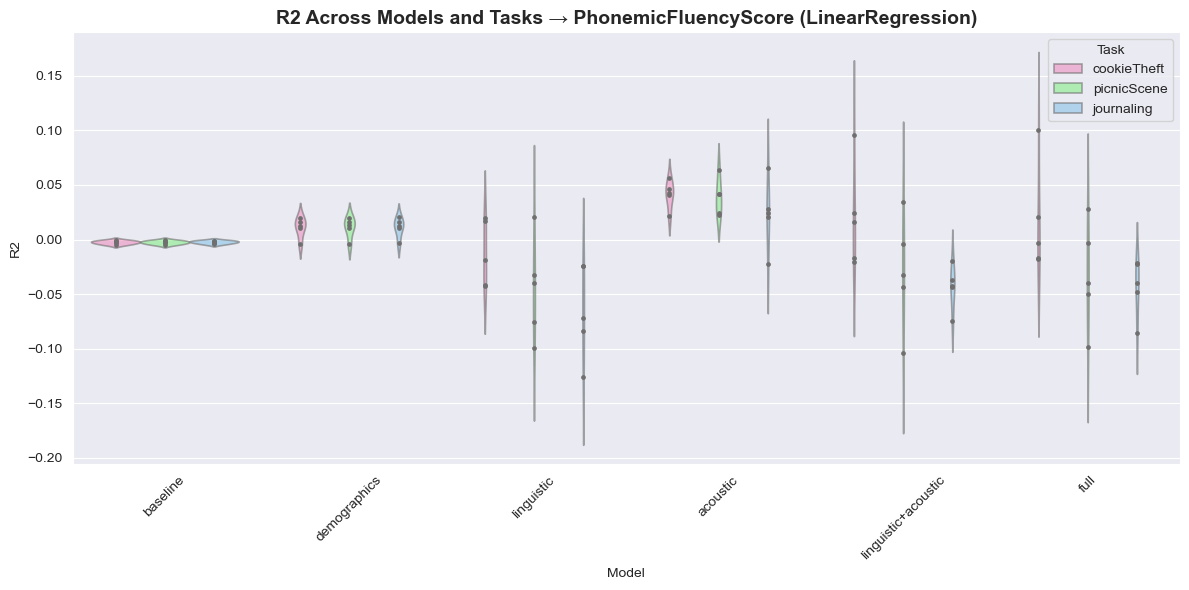

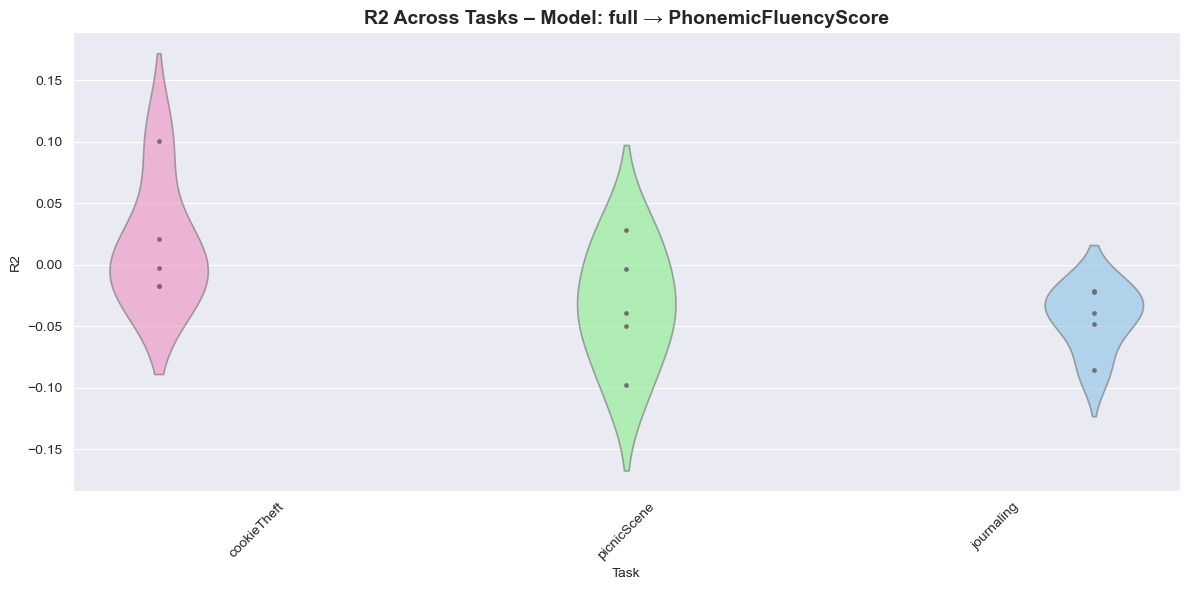

In [109]:
# plot all models and tasks
plot_model_task_violin(df_folds, metric="r2", target=target, model_to_plot=None, save_path=save_path, )
# plot only one model type
plot_model_task_violin(df_folds, metric="r2", target=target, model_to_plot="full", save_path=save_path)

In [110]:
def plot_model_task_pointplot(summary_df, save_path=None, target=None):
    summary_df["model"] = summary_df["model"].astype(CategoricalDtype(categories=model_order, ordered=True))
    summary_df["task"] = summary_df["task"].astype(CategoricalDtype(categories=task_order, ordered=True))

    # plot
    plt.figure(figsize=(12, 6))
    ax = sns.pointplot(
        data=summary_df,
        x="model",
        y="r2_mean",
        hue="task",
        dodge=0.5,
        linestyle="None",
        palette=color_palette,
        errorbar=None
    )

    # add CI bars
    for i, row in summary_df.iterrows():
        x_pos = model_order.index(row["model"]) + (-0.25 if row["task"] == "cookieTheft" else 0 if row["task"] == "picnicScene" else 0.25)
        plt.errorbar(
            x=x_pos,
            y=row["r2_mean"],
            yerr=[[row["r2_mean"] - row["r2_ci_low"]], [row["r2_ci_high"] - row["r2_mean"]]],
            fmt='none',
            ecolor='black',
            elinewidth=1,
            capsize=3
        )
        # annotate R²
        plt.text(
            x_pos - 0.05,
            row["r2_mean"],
            f"{row['r2_mean']:.2f}",
            ha='center',
            va='bottom',
            fontsize=9
        )

    plt.title(f"Mean R² per Model and Task → {target} ({model_type_name})", fontsize=14, fontweight="bold")
    plt.ylabel("Mean R² with 95% CI")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.legend(title="Task")
    plt.tight_layout()

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, f"pointplot_models_tasks_{target}_{model_type_name}.png"), dpi=300)

    plt.show()

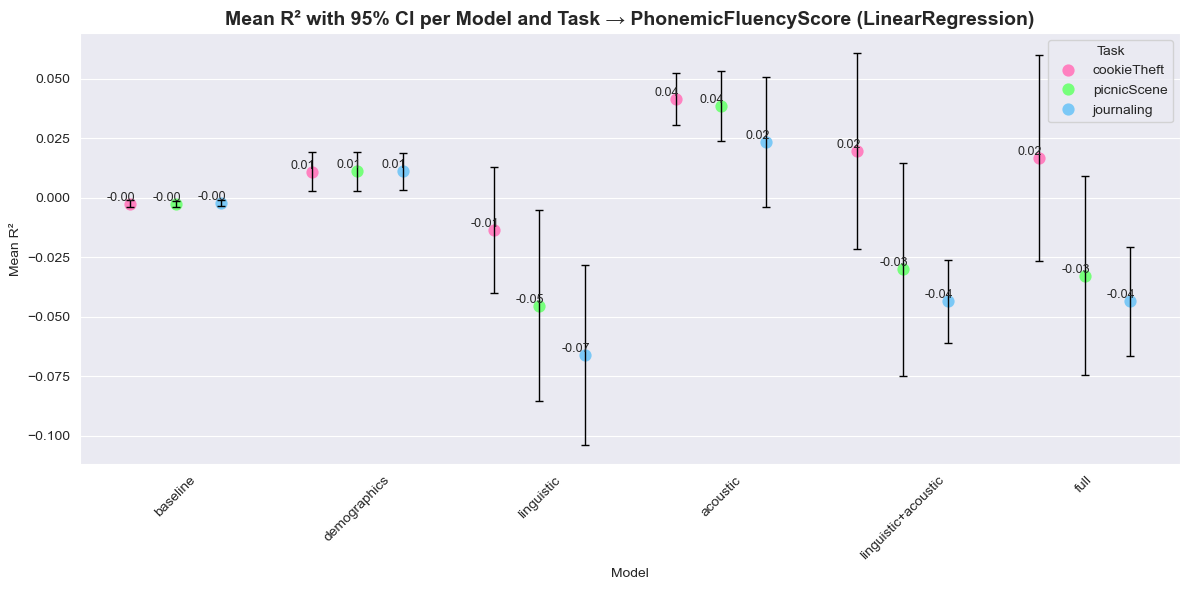

In [111]:
plot_model_task_pointplot(summary_df, save_path=save_path, target=target)